# Cartpole Example
This example demonstrates global adversarial stress testing in the classic inverted pendulum environment. 
- **System under test:** pre-trained DQN controller with very low natural rate of failure.
- **Failure criterion:** inverted pendulum exceeds threshold angle or cart exceeds theshold distance from origin. 
- **Stochastic disturbance:** wind gusts in horizontal direction, normally distributed in strength.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole`
   Resolving package versions...
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole\Project.toml`
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole\Manifest.toml`


# Loading cart-pole controller (SUT)

In [2]:
# to learn
using ReinforcementLearning

# to load
using BSON
using Flux
using NNlib
using Random
using StableRNGs

In [3]:
# This function can be invoked to re-train the DQN policy if desired.
function learn_policy()
    seed = 123
    rng = StableRNG(seed)
    env = CartPoleEnv(; T = Float32, rng = rng)
    ns, na = length(state(env)), length(action_space(env))

    policy = Agent(
        policy = QBasedPolicy(
            learner = BasicDQNLearner(
                approximator = NeuralNetworkApproximator(
                    model = Chain(
                        Dense(ns, 128, relu; init = glorot_uniform(rng)),
                        Dense(128, 128, relu; init = glorot_uniform(rng)),
                        Dense(128, na; init = glorot_uniform(rng)),
                    ) |> cpu,
                    optimizer = ADAM(),
                ),
                batch_size = 32,
                min_replay_history = 100,
                loss_func = Flux.huber_loss,
                rng = rng,
            ),
            explorer = EpsilonGreedyExplorer(
                kind = :exp,
                ϵ_stable = 0.01,
                decay_steps = 500,
                rng = rng,
            ),
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 1000,
            state = Vector{Float32} => (ns,),
        ),
    )
    stop_condition = StopAfterStep(100_000)
    hook = ComposedHook(TotalRewardPerEpisode(), TimePerStep())
    
    ex = Experiment(policy, env, stop_condition, hook, "")
    run(ex)
    policy = policy.policy
    policy.explorer.is_training = false
    BSON.@save "dqn_policy.bson" policy
end

learn_policy (generic function with 1 method)

In [4]:
load_policy() = BSON.load("dqn_policy.bson")[:policy]

load_policy (generic function with 1 method)

# Simulation

In [5]:
using Random
using AdaStress
import AdaStress.BlackBox
using Distributions
using Plots
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

In [6]:
Base.@kwdef mutable struct CartPoleSim <: Interface.GrayBox
    env::ReinforcementLearning.AbstractEnv = CartPoleEnv()
    tmax::Float64 = 50.0
    pi::ReinforcementLearning.AbstractPolicy = load_policy()
    x_dist::Interface.Environment = Interface.Environment(:wind => Normal(0.0, 0.01))
    log::Dict{Symbol, Any} = Dict{Symbol, Any}()
    logging::Bool = false
end

CartPoleSim

In [7]:
function Interface.reset!(sim::CartPoleSim)
    ReinforcementLearning.reset!(sim.env)
    if sim.logging
        sim.log[:s] = []
        sim.log[:x] = []
        sim.log[:a] = []
        push!(sim.log[:s], Interface.observe(sim))
    end
end

Interface.environment(sim::CartPoleSim) = sim.x_dist

Interface.observe(sim::CartPoleSim) = push!(copy(ReinforcementLearning.state(sim.env)), sim.env.t / sim.tmax)

function Interface.step!(sim::CartPoleSim, x::Interface.EnvironmentValue)
    a = sim.pi(sim.env)
    s = ReinforcementLearning.state(sim.env)
    s[2] += x[:wind]
    sim.env(a)
    if sim.logging
        push!(sim.log[:s], Interface.observe(sim))
        push!(sim.log[:x], x[:wind])
        push!(sim.log[:a], a)
    end     
end

Interface.isterminal(sim::CartPoleSim) = sim.env.t >= sim.tmax

function Interface.isevent(sim::CartPoleSim)
    state, params = sim.env.state, sim.env.params
    return abs(state[1]) > params.xthreshold || abs(state[3]) > params.thetathreshold
end

interval_dist(x::Real, r::Real) = interval_dist(x, -r, r)

interval_dist(x::Real, l::Real, u::Real) = (l < x < u) ? min(x - l, u - x) : zero(x)

function Interface.distance(sim::CartPoleSim)
    s = ReinforcementLearning.state(sim.env)
    dx = interval_dist(s[1], sim.env.params.xthreshold)
    dθ = interval_dist(s[3], sim.env.params.thetathreshold)
    d = sqrt(dx^2 + dθ^2)
    return d
end

function mdp_env(σ::Float64)
    mdp = Interface.ASTMDP(CartPoleSim())
    mdp.reward.event_bonus = 100.0
    mdp.sim.x_dist[:wind] = Normal(0.0, σ)
    return mdp
end

mdp_env (generic function with 1 method)

# Trajectory examples (undisturbed)

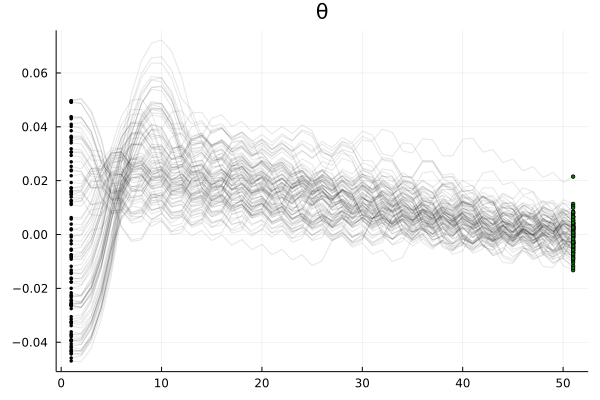

In [8]:
Random.seed!(0)
p = plot(title="\\theta")
mdp = mdp_env(0.025)
mdp.sim.logging = true
n_eps = 100

for _ in 1:n_eps
    e = AdaStress.Solvers.replay!(mdp, AdaStress.Solvers.NullPolicy())
    t = collect(1:length(mdp.sim.log[:s]))
    θ = getindex.(mdp.sim.log[:s], 3)
    plot!(p, t, θ, label=:none, lc=(e ? :red : :black), alpha=0.1)
    scatter!(p, [t[1]], [θ[1]], mc=:black, ms=2.0, label=:none)
    scatter!(p, [t[end]], [θ[end]], mc=(e ? :red : :green), ms=2.0, label=:none)
end
p

# Natural failure prevalence (disturbances but no AST)

In [9]:
Random.seed!(0)
c = 0
mdp = mdp_env(0.025)
n_eps = 10_000

@showprogress for _ in 1:n_eps
    c += AdaStress.Solvers.replay!(mdp, AdaStress.Solvers.RandomPolicy())
end
println("$c naturally-occurring failure$(c == 1 ? "" : "s") found out of $n_eps episodes.")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


14 naturally-occurring failures found out of 10000 episodes.


# AST

In [10]:
AdaStress.enable("SoftActorCritic")
using AdaStress.SoftActorCritic

┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\adastress\src\utils.jl:93


In [11]:
Random.seed!(0)

sac = AdaStress.SoftActorCritic.SAC(;
    obs_dim=5, 
    act_dim=1,
    act_mins=-3.0*ones(1),
    act_maxs=3.0*ones(1),
    hidden_sizes=[30,30,30],
    q_optimizer=AdaBelief(1e-4),
    pi_optimizer=AdaBelief(1e-4),
    alpha_optimizer=AdaBelief(1e-4),
    gamma=1.0,
    num_q=3,
    max_buffer_size=100_000,
    batch_size=1024,
    epochs=150,
    steps_per_epoch=1_000,
    start_steps=10_000,
    max_ep_len=100,
    update_after=10_000,
    update_every=1_000,
    num_batches=100,
    num_test_episodes=100,
    displays=[(:fails, mdp->Interface.isevent(mdp.sim))],
    use_gpu=false
)

ac, info = sac(() -> mdp_env(0.025))

Progress: 100%|█████████████████████████████████████████| Time: 0:03:42
  epoch:  150
  score:  75.326614
  stdev:  0.87628365
  fails:  0.96


(MLPActorCritic(SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 1), Dense(30, 1), Float32[-3.0], Float32[3.0], Random._GLOBAL_RNG(), nothing, false), SoftActorCritic.MLPQFunction[SoftActorCritic.MLPQFunction(Chain(Dense(6, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(6, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(6, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))]), Dict{String, Any}("score" => Any[-1.2982365f0, -0.45816767f0, -0.26920554f0, -0.24219736f0, -0.27620187f0, -0.18340729f0, -0.17002267f0, -1.0217903f0, -0.46302056f0, -0.3155263f0  …  75.00554f0, 74.15143f0, 73.943085f0, 75.13819f0, 75.35046f0, 74.6657f0, 75.3588f0, 75.16508f0, 74.918846f0, 75.326614f0], "stdev" => Any[0.09985117f0, 0.07230078f0, 0.07011744f0, 0.07710096f0, 0.07252703f0, 0.06111533f0, 0.06

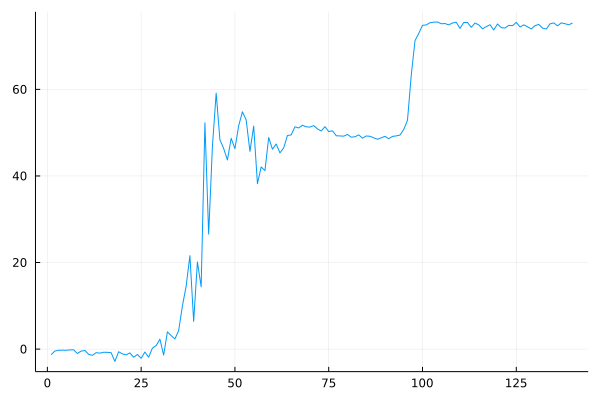

In [12]:
plot(info["score"]; label=:none)

# Sample trajectories

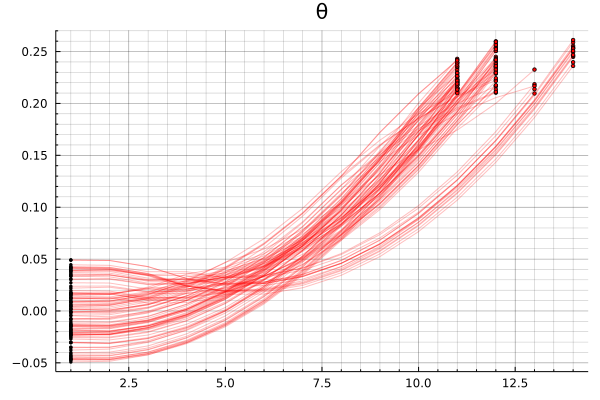

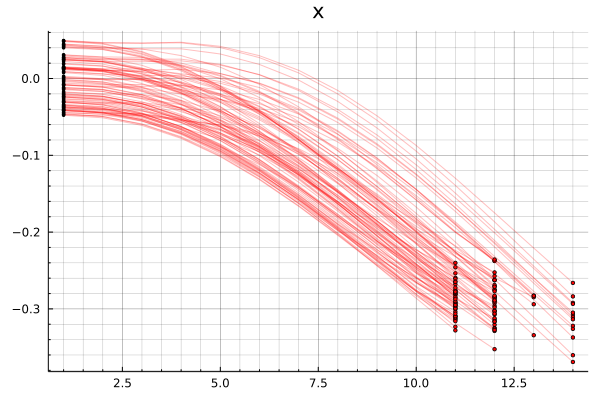

In [13]:
Random.seed!(0)
pθ = plot(; title="\\theta", ga=0.5, minorgrid=true, minorgridalpha=0.25)
px = plot(; title="x", ga=0.5, minorgrid=true, minorgridalpha=0.25)
mdp = mdp_env(0.1)
mdp.sim.logging = true
n_eps = 100

for _ in 1:n_eps
    e = AdaStress.Solvers.replay!(mdp, ac) 
    t = collect(1:length(mdp.sim.log[:s]))
    θ = getindex.(mdp.sim.log[:s], 3)
    x = getindex.(mdp.sim.log[:s], 1)
    
    plot!(pθ, t, θ, label=:none, lc=(e ? :red : :black), alpha=0.25)
    scatter!(pθ, [t[1]], [θ[1]], mc=:black, ms=2.0, label=:none)
    scatter!(pθ, [t[end]], [θ[end]], mc=(e ? :red : :green), ms=2.0, label=:none)
    
    plot!(px, t, x, label=:none, lc=(e ? :red : :black), alpha=0.25)
    scatter!(px, [t[1]], [x[1]], mc=:black, ms=2.0, label=:none)
    scatter!(px, [t[end]], [x[end]], mc=(e ? :red : :green), ms=2.0, label=:none)
end
display(pθ)
display(px)

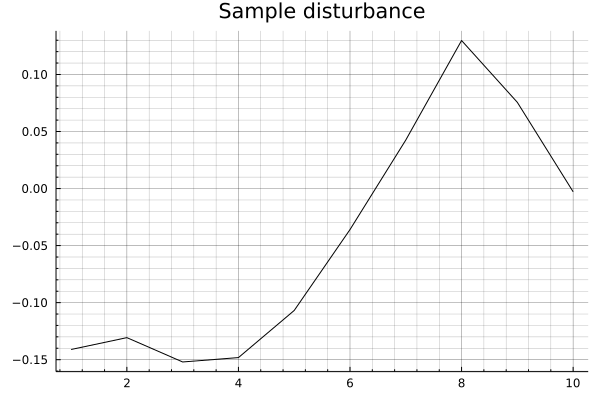

In [14]:
plot(mdp.sim.log[:x]; title="Sample disturbance", label=:none, lc=:black, ga=0.5, minorgrid=true, minorgridalpha=0.25)

# Animation

In [15]:
function Circle(xc::Real, yc::Real, r::Real; n::Int64=100)
    θ = range(0, 2π; length=n+1)
    xs = @. xc + r*cos(θ)
    ys = @. yc + r*sin(θ)
    return Shape(xs, ys)
end

function Rectangle(xc::Real, yc::Real, l::Real, h::Real)
    xs = [xc - l/2, xc + l/2, xc + l/2, xc - l/2]
    ys = [yc - h/2, yc - h/2, yc + h/2, yc + h/2]
    return Shape(xs, ys)
end

Rectangle (generic function with 1 method)

In [16]:
function movie(sim::CartPoleSim, filename::String="animation")
    cart_length = 0.5
    cart_height = 0.25
    wheel_offset = 0.2
    wheel_height = 0.025
    wheel_radius = 0.05
    pole_length = 1.0

    x_grid = 10
    y_grid = 5
    σ_max = 3
    xlim = sim.env.params.xthreshold * [-1, 1]
    ylim = [0, cart_height + pole_length + 0.1]
    xs = range(xlim..., length=x_grid)
    ys = range(ylim..., length=y_grid)
    X = [x for x in xs for y in ys]
    Y = [y for x in xs for y in ys]
    h = xs[2] - xs[1]

    log = sim.log
    anim = @animate for i in 1:length(log[:s])
        x = log[:s][i][1]
        θ = log[:s][i][3]
        i_trunc = min(i, length(log[:s]) - 1)
        a = log[:a][i_trunc]
        w = log[:x][i_trunc] * 2

        # empty scene
        p = plot(; 
            xlim=xlim, 
            ylim=ylim, 
            yaxis=false, 
            minorticks=10, 
            yticks=false, 
            aspect_ratio=:equal, 
            label=:none
        )

        # wind disturbance
        quiver!(p, X, Y; quiver=(x,y)->[w, 0.0], lc=:dodgerblue)

        # pole
        color = abs(θ) < sim.env.params.thetathreshold ? :blue : :red
        x_pole, y_pole = x, cart_height
        xs = x_pole .+ [0, pole_length] * sin(θ)
        ys = y_pole .+ [0, pole_length] * cos(θ)
        plot!(p, xs, ys; lw=5, lc=color, label=:none)
        scatter!(p, [xs[1]], [ys[1]]; ms=5, mc=color, label=:none)
        scatter!(p, [xs[2]], [ys[2]]; ms=8, mc=color, label=:none)

        # cart body
        color = abs(x) < sim.env.params.xthreshold ? :gray : :red
        plot!(p, Rectangle(x, cart_height/2, cart_length, cart_height); fill=color, label=:none)

        # cart wheels
        plot!(p, Circle(x + wheel_offset, wheel_height, wheel_radius); lw=2, fill=:gray, label=:none)
        plot!(p, Circle(x - wheel_offset, wheel_height, wheel_radius); lw=2, fill=:gray, label=:none)

        # controller force
        dir = a == 2 ? 1 : -1
        xs = (x - dir * cart_length / 2) * [1, 1] .- dir * [0.25, 0]
        ys = cart_height / 2 * [1, 1] 
        plot!(p, xs, ys; arrow=true, lc=:red, lw=4, label=:none)

        p
    end

    return gif(anim, "$filename.mp4", fps = 15)
end

movie (generic function with 2 methods)

In [17]:
Random.seed!(0)
mdp = mdp_env(0.1)
mdp.sim.logging = true

AdaStress.Solvers.replay!(mdp, ac) 
movie(mdp.sim)

┌ Info: Saved animation to 
│   fn = C:\Users\rlipkis\.julia\dev\adastress\examples\cartpole\animation.mp4
└ @ Plots C:\Users\rlipkis\.julia\packages\Plots\YAlrZ\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\rlipkis\\.julia\\dev\\adastress\\examples\\cartpole\\animation.mp4")